In [26]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import seaborn as sns
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import sklearn
from scipy.signal import savgol_filter
from sklearn import preprocessing
import statistics 
from tqdm import tqdm
import copy
from random import randint 
import math
from matplotlib import ticker
# from google.colab import files
from fbprophet import Prophet
import datetime

In [27]:
# from google.colab import drive
# drive.mount('/content/drive')

In [28]:
# %cd /content/drive/'My Drive'/'CS145_Kaggle'
# %ls


In [29]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")
full_testdf = pd.read_csv("full_test.csv")
# mobility = pd.read_csv("summarized_mobility.csv")

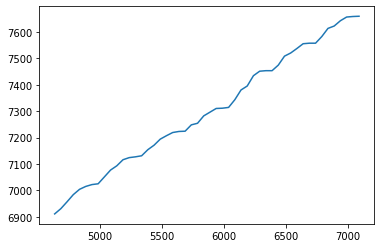

In [30]:
traindf[traindf.Province_State == "Pennsylvania"].Deaths.iloc[-50:].plot()

In [31]:
testdf.head()

,ForecastID,Province_State,Date,Confirmed,Deaths
0,0,Alabama,09-01-2020,127616,2200
1,1,Alaska,09-01-2020,5297,39
2,2,Arizona,09-01-2020,202342,5044
3,3,Arkansas,09-01-2020,61497,814
4,4,California,09-01-2020,715617,13150


In [32]:
# mobility.head()

### Fill-in incomplete-test csv (same format as submission)

In [33]:
df2 = pd.read_csv("train.csv", usecols=["Province_State", "Confirmed", "Deaths"])
df2.tail()

,Province_State,Confirmed,Deaths
7095,Virginia,120575,2580
7096,Washington,74635,1915
7097,West Virginia,10249,215
7098,Wisconsin,75603,1122
7099,Wyoming,3850,37


In [34]:
teststates = testdf.Province_State.unique().tolist()
newdfstates = df2.Province_State.unique().tolist()
skipstate = []
skipidx = []
idx = 0
for state in newdfstates:
  if state not in teststates:
    skipstate += [state]
    skipidx += [idx]
  idx += 1
skipstate

[]

In [35]:
df2 = df2.drop(index = skipidx)
df2 = df2.reset_index(drop=True)
print(len(df2))
df2.head()

7100


,Province_State,Confirmed,Deaths
0,Alabama,3563,93
1,Alaska,272,8
2,Arizona,3542,115
3,Arkansas,1280,27
4,California,22795,640


In [36]:
tempdf = copy.copy(testdf)
tempdf.iloc[0:1*50, 3:5] = df2[['Confirmed', 'Deaths']]

In [37]:
for i in range(26):
  df = pd.read_csv("{}.csv".format(i+1), usecols=["Province_State", "Confirmed", "Deaths"])
  df = df.drop(index = skipidx)
  df = df.set_index(np.arange(i*50, (i+1)*50))
  assert len(df) == 50
  testdf.iloc[i*50:(i+1)*50, 3:5] = df[['Confirmed', 'Deaths']]
  

FileNotFoundError: [Errno 2] No such file or directory: '1.csv'

In [ ]:
from google.colab import files
testdf.to_csv('test.csv')  
files.download("test.csv")

### Fill-in complete test csv (all features as train)

In [ ]:
traindf.head()

In [ ]:
all_features = traindf.columns.to_list()
all_features.remove('ID')
all_features.remove('Date')

In [ ]:
df = pd.read_csv("1.csv", usecols= all_features)
df.head()

In [ ]:
teststates = traindf.Province_State.unique().tolist()
newdfstates = df.Province_State.unique().tolist()
skipstate = []
skipidx = []
idx = 0
for state in newdfstates:
  if state not in teststates:
    skipstate += [state]
    skipidx += [idx]
  idx += 1
skipstate

In [ ]:
df = df.drop(index = skipidx)

In [38]:
import datetime
start_date = datetime.date(2020, 9, 1)
delta = datetime.timedelta(days=1)
str(start_date + delta)

'2020-09-02'

In [39]:
df["Date"] = start_date
df.head()

NameError: name 'df' is not defined

In [ ]:
df["ForecastID"] = np.arange((1-1)*50, (1)*50)
df.head()

In [ ]:
start_date = datetime.date(2020, 9, 2) 
delta = datetime.timedelta(days=1)
new_testdf = []
new_testdf.append(df) #do this first as a safety check so error raised if cols not match

for i in range(1, 26):
  df = pd.read_csv("{}.csv".format(i+1), usecols= all_features)
  df = df.drop(index = skipidx)
  df = df.set_index(np.arange(i*50, (i+1)*50))
  df['ID'] = np.arange(i*50, (i+1)*50)
  df["Date"] = start_date
  start_date += delta
  assert len(df) == 50
  new_testdf.append(df)

new_testdf = pd.concat(new_testdf)

In [ ]:
traindf.shape, testdf.shape, new_testdf.shape

In [ ]:
features = new_testdf.columns.tolist() 
features = features[-2:-1] + features[0:1] + features[-1:] + features[1:-2]
new_testdf = new_testdf[features]
all(new_testdf.columns == traindf.columns)

In [ ]:
from google.colab import files
new_testdf.to_csv('full_test.csv')
files.download("full_test.csv")

### Data exploration

In [ ]:
print(traindf.shape)
traindf.head()
traindf.tail()

#### Translate states to numerical values (by category) 

In [ ]:
# translate Province_State to numerical values
unique_states = traindf.Province_State.unique()
print(unique_states)

In [ ]:
le = preprocessing.LabelEncoder() 
le.fit(unique_states)
le.classes_[:10]

In [ ]:
traindf["State_code"] = le.transform(traindf.Province_State)
features = traindf.columns.tolist() 
features = features[4:6] + features[0:2] + features[-1:] + features[2:4] + features[6:-1]
traindf = traindf[features]
traindf.iloc[48:52, :]

In [ ]:
temp_df = mobility.melt(id_vars=['states'])
temp_df 

In [ ]:
traindf['Mobility'] = temp_df.iloc[:,2]
traindf.iloc[48:52,:]

#### Check distribution and fill na

In [ ]:
# Any NA?
traindf.isnull().values.any()

In [ ]:
features = traindf.columns
features_na = []
for feature in features:
  na_count = traindf[feature].isnull().sum()
  if na_count > 0:
   features_na += [feature]
  print("{0: <20} : {1}".format(feature, na_count))

In [ ]:
# All states have NA in Hospitalization data (even after mid-June)
len(traindf[traindf["Hospitalization_Rate"].isna()]["Province_State"].unique())

In [ ]:
# Fill with zeros for now?
traindf['Hospitalization_Rate'] = traindf['Hospitalization_Rate'].fillna(0)
traindf['People_Hospitalized'] = traindf['People_Hospitalized'].fillna(0)

In [ ]:
traindf['Recovered'] = traindf['Recovered'].fillna(0)
traindf['Recovered'] 

In [ ]:
for feature in features_na:
  sns.displot(data=traindf, x=feature, kde=True)
  plt.show()

In [ ]:
traindf.corr()

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(traindf.corr(),
            vmin=-1,
            cmap='coolwarm',
            annot=True)

In [ ]:
X_train = traindf.iloc[:, 4:]
y_train = traindf.iloc[:, 0:2]
X_train.shape, y_train.shape

## Models

### Separate data by state

In [ ]:
train_by_state = {}
for state in unique_states:
  train_by_state[state] = traindf[traindf.Province_State == state]

### Linear with Prophet adjusted

In [ ]:
from fbprophet.plot import add_changepoints_to_plot

In [ ]:
sample_train = train_by_state["California"]
sample_test = testdf[testdf.Province_State == "California"]
test_size = len(sample_test)

basic_model = Prophet()
basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = basic_model.make_future_dataframe(periods=test_size)
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(20), sample_train.iloc[-20:].Deaths.values, label = "train")
ax1.plot(np.arange(20, 46), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(20, 46), forecast.yhat.values[20:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[20:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
import torch.nn as nn
import torch
import numpy as np
import torch.optim as optim
import pandas as pd
from scipy.signal import savgol_filter
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

In [ ]:
degree = 3
start = 110
alpha = .1
window = 17

In [ ]:
feature = 'Deaths'
Death_pred = []
state = "California"
ds = train_by_state[state]
value = ds[feature].values
value = savgol_filter(value.reshape(-1), window, degree)
combine = [[value[i]] for i in range(len(value))]

y = np.array([value[start:]]).reshape(-1, 1)
x = [[i + start] for i in range(142-start)]

model = Pipeline([
    ("poly", PolynomialFeatures(degree=2)),
    ("lasso_reg", Ridge(alpha=alpha))
])
model.fit(x, y)

x_test = [[i + 142] for i in range(test_size)]

y_hat = model.predict(x_test)
Death_pred.append(y_hat)

### Weighted average example

In [ ]:
synth_pred = 0.8* np.array(Death_pred[0]).ravel() + 0.2 * forecast.yhat[-(len(sample_test)):].values #simple weighted average
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

### Ratio example

In [ ]:
### Sythn using daily ratio change
def calc_ratio(data):
  ratios = []
  for i in range(len(data)-1):
    ratios.append(data[i+1]/ data[i])
  return np.array(ratios)

calc_ratio(forecast.yhat.values[-test_size:])

In [ ]:
synth_pred = np.zeros(test_size)
synth_pred[0] = Death_pred[0][0]
synth_pred[1:] = np.array(Death_pred[0]).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])

In [ ]:
#pure ratio adds bias, we will do sth about it below
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

In [ ]:
synth_pred -= 2 * (np.mean(synth_pred) - np.mean(Death_pred[0]))

In [ ]:
ax = plt.gca()

ax.scatter(np.arange(test_size), sample_test.Deaths.values, label = "Actual")
ax.scatter(np.arange(test_size), Death_pred[0], label = "Linear")
#ax.scatter(np.arange(test_size), forecast.yhat.values[-test_size:], label = "Prophet")
ax.scatter(np.arange(test_size), synth_pred, label = "Synthesized")
ax.legend()

plt.plot()

### Evaluating weighted avg, ratio with previous linear

In [ ]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
MAPE(synth_pred, sample_test.Deaths)

In [ ]:
# All model performances
test_result = {}
feature = 'Deaths'

for state in unique_states:

  ######=========================================######
  # Linear model
  Death_pred = []
  sample_train = train_by_state[state]
  sample_test = testdf[testdf.Province_State == state]
  test_size = len(sample_test)

  ds = sample_train
  value = ds[feature].values
  value = savgol_filter(value.reshape(-1), window, degree)
  combine = [[value[i]] for i in range(len(value))]

  y = np.array([value[start:]]).reshape(-1, 1)
  x = [[i + start] for i in range(142-start)]

  model = Pipeline([
      ("poly", PolynomialFeatures(degree=2)),
      ("lasso_reg", Ridge(alpha=alpha))
  ])
  model.fit(x, y)

  x_test = [[i + 142] for i in range(test_size)]

  y_hat = model.predict(x_test)
  Death_pred.append(y_hat)

  ######=========================================######
  # Prophet
  basic_model = Prophet()
  basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

  future = basic_model.make_future_dataframe(periods=test_size)
  forecast = basic_model.predict(future)


  ######=========================================######
  # Synthesized
  avrg_synth  = 0.8* np.array(Death_pred[0]).ravel() + 0.2 * forecast.yhat[-(len(sample_test)):].values

  calc_ratio(forecast.yhat.values[-test_size:])
  ratio_synth = np.zeros(test_size)
  ratio_synth[0] = Death_pred[0][0]
  ratio_synth[1:] = np.array(Death_pred[0]).ravel()[1:] * calc_ratio(forecast.yhat.values[-test_size:])

  ######=========================================######
  # Eval and save result
  test_result[state] = {}
  lin_MAPE = MAPE(Death_pred[0], sample_test.Deaths)
  test_result[state]["linear_Eval"] = lin_MAPE
  avg_MAPE = MAPE(avrg_synth, sample_test.Deaths)
  test_result[state]["W_avrg_Eval"] = avg_MAPE
  ratio_MAPE = MAPE(ratio_synth, sample_test.Deaths)
  test_result[state]["Ratio_Eval"] = ratio_MAPE
  test_result['avr_pred'] = avrg_synth
  test_result['ratio_pred'] = avrg_synth
  test_result['linear'] = Death_pred[0]

  print("state: {}, linear: {}, avg: {}, ratio:{}".format(state, lin_MAPE, avg_MAPE, ratio_MAPE))
  print("===========")



In [ ]:
max_avg_MAPE = -1
max_ratio_MAPE = -1
better_before = {}

for state in unique_states:
  state_data = test_result[state]
  prev = state_data["linear_Eval"]
  avg = state_data["W_avrg_Eval"]
  ratio =  state_data["Ratio_Eval"]

  if avg > max_avg_MAPE:
    max_avg_MAPE = avg
  
  if avg > max_ratio_MAPE:
    max_ratio_MAPE = ratio

  # MAPE so the smaller the better
  if avg < prev  or ratio < prev:
    if ratio < avg:
      better_before[state] = ("ratio", prev, ratio)
    else:
      better_before[state] = ("avg", prev, avg)

(max_avg_MAPE, max_ratio_MAPE)

In [ ]:
len(set(better_before.keys()))

In [ ]:
test_result

In [ ]:
mob_df = pd.read_csv("summarized_mobility.csv")

In [ ]:
mob_df.head()

In [ ]:
datetime.datetime(2020, 4, 12).weekday()

### 2nd deriv approx (w/ effect of window size)

In [ ]:
# 2nd deriv midpoint approx
def second_der_approx(f0, f1, f2, h = 1):
  return 1/(h**2) * (f0 - 2*f1 + f2) 

In [ ]:
def calc_2nd_deriv(input, feature = None, numpy = False):
  if feature is not None and (not numpy):
    data = input[feature].values
  else:
    data = input

  n = len(data)
  approx = np.ones(n)
  approx[0] = np.nan
  approx[-1] = np.nan
  for i in np.arange(1, n-1):
    # assume calculations by day
    approx[i] = second_der_approx(data[i-1], data[i], data[i+1], 1)
  
  return approx

In [ ]:
degree = 3
alpha = .1
window = 21
CA_Death_smoothed = savgol_filter(train_by_state["California"].Deaths.values.ravel(), window, degree)

In [ ]:
nrows = 2
ncols = 2
fig = plt.figure(figsize=(10, 8))

### Data plot ### 
ax = fig.add_subplot(nrows, ncols, 1)
ax.plot(train_by_state["California"].Deaths.values)
ax.set_title("CA Death raw")

ax = fig.add_subplot(nrows, ncols, 2)
ax.plot(CA_Death_smoothed)
ax.set_title("CA Death Smoothened")

### 2nd deriv ### 
CA_raw_2nd = calc_2nd_deriv(train_by_state["California"], "Deaths")
ax = fig.add_subplot(nrows, ncols, 3)
ax.plot(CA_raw_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("CA Death raw 2nd deriv")

CA_Smooth_2nd = calc_2nd_deriv(CA_Death_smoothed, numpy = True)
ax = fig.add_subplot(nrows, ncols, 4)
ax.plot(CA_Smooth_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("CA Death smoothened 2nd deriv")

######
plt.show()

In [ ]:
degree = 3
alpha = .1
window = 21
ID_Death_smoothed = savgol_filter(train_by_state["Idaho"].Deaths.values.ravel(), window, degree)

In [ ]:
nrows = 2
ncols = 2
fig = plt.figure(figsize=(10, 8))

### Data plot ### 
ax = fig.add_subplot(nrows, ncols, 1)
ax.plot(train_by_state["Idaho"].Deaths.values)
ax.set_title("ID Death raw")

ax = fig.add_subplot(nrows, ncols, 2)
ax.plot(ID_Death_smoothed)
ax.set_title("ID Death Smoothened")

### 2nd deriv ### 
ID_raw_2nd = calc_2nd_deriv(train_by_state["Idaho"], "Deaths")
ax = fig.add_subplot(nrows, ncols, 3)
ax.plot(ID_raw_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("ID Death raw 2nd deriv")

ID_Smooth_2nd = calc_2nd_deriv(ID_Death_smoothed, numpy = True)
ax = fig.add_subplot(nrows, ncols, 4)
ax.plot(ID_Smooth_2nd)
#ax.set_ylim(-220, 220)
ax.set_title("ID Death smoothened 2nd deriv")

######
plt.show()

In [ ]:
degree = 3
alpha = .1
nrows = 2
ncols = 4


fig = plt.figure(figsize=(16, 8))
for i,state in enumerate(["California", "Idaho"]):
  for j, window in enumerate([7, 15, 21, 43]):
    
    Death_smoothed = savgol_filter(train_by_state[state].Deaths.values.ravel(), window, degree)
    Smooth_2nd = calc_2nd_deriv(Death_smoothed, numpy = True)
    ax = fig.add_subplot(nrows, ncols, 4*i+(j+1))
    #ax.plot(train_by_state[state].Deaths.values)
    ax.set_title(f"{state} Death with window = {window}")
    ax.plot(Smooth_2nd)
    


#### Example of 2nd derivative approx. 

In [ ]:
print(np.nanmin(cal_2nd_deriv), np.nanargmin(cal_2nd_deriv))
crit_ind = np.nanargmin(cal_2nd_deriv)
train_by_state["California"].Deaths[crit_ind-1:crit_ind+2].values 

In [ ]:
fig = plt.figure(figsize=(4, 9))
ax = fig.add_subplot(2, 1, 1)
ax.scatter(np.arange(9), train_by_state["California"].Deaths[120:129].values)
ax.set_xlim(-5, 35)
ax = fig.add_subplot(2, 1, 2)
ax.plot(cal_2nd_deriv[123:126])
ax.set_xlim(-5, 35)
plt.show()

In [ ]:
id_2nd_deriv = calc_2nd_deriv(train_by_state["Idaho"], "Deaths") 

In [ ]:
plt.plot(id_2nd_deriv)

### Exponential smoothing for baseline

In [ ]:
y_train

In [ ]:
y_train["Deaths"].plot()

In [ ]:
y_train["Recovered"].plot(c = "orange")

In [ ]:
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from random import random
# contrived dataset
data = [x + random() for x in range(1, 100)]
# fit model
model = ARIMA(data, order=(1, 1, 1))
model_fit = model.fit()
# make prediction
yhat = model_fit.predict(len(data), len(data), typ='levels')
print(yhat)

In [ ]:
y_pred = y_train.rolling(2, win_type='gaussian').sum(std=3)

##### Separate prediction for each state

In [ ]:
traindf[traindf.Province_State == "California"]

In [ ]:
state_df_dict["California"]

In [ ]:
state_df_dict = {}
for state in unique_states:
  state_df_dict[state] = traindf[traindf.Province_State == state]
  #print(state, len(state_df_dict[state]))

In [ ]:
# Expnt. Moving Avr.
def ema(data, alpha):
  n = len(data)
  mov_avr = np.ones((n,1))
  mov_avr[0] = data[0]
  for i in np.arange(1,n):
    mov_avr[i] = alpha * data[i] + (1-alpha) * mov_avr[i-1]
  return mov_avr


In [ ]:
def predict(mov_avr, days, alpha):
  pred = np.ones((days,1))
  for i in np.arange(1,n):
    pred[i] = alpha * mov_avr[i] + (1-alpha) * mov_avr[i-1]
  return pred

In [ ]:
predict(state_df_dict["California"].Deaths, 25, 0.5)

In [ ]:
plt.plot(ema(state_df_dict["California"].Deaths.values, 0.5), state_df_dict["California"].Deaths)

In [ ]:
ema(y_train.Deaths, 0.5)

In [ ]:
y_train['D_SMA_10'] = y_train.Deaths.rolling(10, min_periods=1).mean()
y_train['D_SMA_20'] = y_train.Deaths.rolling(20, min_periods=1).mean()
#y_train['R_SMA_10'] = y_train.Recovered.rolling(10, min_periods=1).mean()
#y_train['R_SMA_20'] = y_train.Recovered.rolling(20, min_periods=1).mean()

In [ ]:
y_train["D_GSMA_10"] = y_train.Deaths.rolling(10, win_type='gaussian').sum(std=3)
y_train["D_GSMA_20"] = y_train.Deaths.rolling(20, win_type='gaussian').sum(std=3)

In [ ]:
y_train['DEMA_0.1'] = y_train.Deaths.ewm(alpha=0.1, adjust=False).mean()
y_train['DEMA_0.2'] = y_train.Deaths.ewm(alpha=0.2, adjust=False).mean()

In [ ]:
y_train

In [ ]:
pairs = [(2,3), (6,7), (8,9)]
for pair in pairs:
  y_train.iloc[:50,  [0,pair[0],pair[1]]].plot()
  plt.show()
  y_train.iloc[-50:, [0,pair[0],pair[1]]].plot()
  plt.show()

In [ ]:
#Other ideas
#use LSTM to train for predicting everything in the next day
#Arima 

### Prophet
#### links: https://facebook.github.io/prophet/docs/quick_start.html. 
#### https://peerj.com/preprints/3190.pdf

In [ ]:
sample_train = train_by_state["California"]
sample_test = testdf[testdf.Province_State == "California"]

In [ ]:
sample_train = sample_train.reset_index(drop= True)
sample_train.head()

In [ ]:
# California
plt.plot(np.arange(142), sample_train.Deaths.values, label = "train")
plt.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
plt.legend()
plt.show()

In [ ]:
# Alaska
plt.plot(np.arange(142), sample_train.Deaths.values, label = "train")
plt.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
plt.legend()
plt.show()

In [ ]:
basic_model = Prophet()
basic_model.fit(sample_train.reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

In [ ]:
future = basic_model.make_future_dataframe(periods=len(sample_test))
future #contains all dates of train and test

In [ ]:
forecast = basic_model.predict(future)
forecast.tail()

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), sample_train.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[142:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[142:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
fig = basic_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), basic_model, forecast)

In [ ]:
basic_model.changepoints

In [ ]:
components_plot = basic_model.plot_components(forecast)

#### Example of prophet

In [ ]:
basic_model = Prophet()
basic_model.fit(sample_train.iloc[-20:].reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = basic_model.make_future_dataframe(periods=len(sample_test))
forecast = basic_model.predict(future)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(20), sample_train.iloc[-20:].Deaths.values, label = "train")
ax1.plot(np.arange(20, 46), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(20, 46), forecast.yhat.values[20:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[20:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
fig = basic_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), basic_model, forecast)

### Prophet with additional regressors

In [ ]:
sample_train.head()

In [ ]:
sample_train.columns

In [ ]:
X_train = sample_train.iloc[:, 5:6]
X_train['Incident_Rate'] = sample_train['Incident_Rate']
X_train['People_Tested'] = sample_train['People_Tested']
X_train['People_Hospitalized'] = sample_train['People_Hospitalized']
X_train['Confirmed'] = sample_train['Confirmed']
X_train['Deaths'] = sample_train["Deaths"]
X_train['Mobility'] = sample_train["Mobility"]
X_train.head()

In [ ]:
future

In [ ]:
feature_future = future.copy()

In [ ]:
for feature in ['Incident_Rate', 'People_Tested', 'Confirmed', 'Mobility']:
  feature_model = Prophet()
  feature_model.fit(sample_train.reset_index() \
              .rename(columns={'Date':'ds',
                               feature:'y'}))

  forecast = feature_model.predict(feature_future)
  future[feature] = forecast.yhat
  feature_model.plot(forecast)
  plt.title(f"{feature} modeled")
  plt.show()

In [ ]:
pro_regressor= Prophet()
pro_regressor.add_regressor('Incident_Rate')
pro_regressor.add_regressor('People_Tested')
#pro_regressor.add_regressor('People_Hospitalized')
pro_regressor.add_regressor('Confirmed')
pro_regressor.add_regressor('Mobility')

pro_regressor.fit(X_train.reset_index(drop= True) \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

forecast = pro_regressor.predict(future)
result = pro_regressor.plot(forecast)

In [ ]:
len(forecast.yhat.values)

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), sample_train.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), sample_test.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[-26:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), sample_test.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[-26:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

### LSTM

In [ ]:
prophet_model = Prophet()
prophet_model.fit(AL_traindf.reset_index() \
              .rename(columns={'Date':'ds',
                               'Deaths':'y'}))

future = prophet_model.make_future_dataframe(periods=len(AL_testdf))
forecast = prophet_model.predict(future)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.arange(142), AL_traindf.Deaths.values, label = "train")
ax1.plot(np.arange(142, 168), AL_testdf.Deaths.values, label = "test")
ax1.plot(np.arange(142, 168), forecast.yhat.values[142:], label = "forecast")
ax1.legend()

ax2.scatter(np.arange(26), AL_testdf.Deaths.values, label = "test")
ax2.scatter(np.arange(26), forecast.yhat.values[142:], label = "forecast")
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()
fig = prophet_model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet_model, forecast)

In [ ]:
AL_traindf = traindf[traindf['Province_State'] == 'Alabama']
AL_testdf = testdf[testdf['Province_State'] == 'Alabama']
value = pd.concat([AL_traindf['Confirmed'],AL_testdf['Confirmed']]).values[:]
real_value = AL_traindf['Confirmed'].values[:]

In [ ]:
value.shape, real_value.shape

In [ ]:
x = []
y = []
seq = 50 
for i in range(len(value)-seq-1):
    x.append(value[i:i+seq])
    y.append(value[i+seq])

In [ ]:
train_x = (torch.tensor(x[0:142 - seq]).float()/100000.).reshape(-1, seq, 1)
train_y = (torch.tensor(y[0:142 - seq]).float()/100000.).reshape(-1, 1)
test_x = (torch.tensor(x[142 - seq:]).float()/100000.).reshape(-1, seq, 1)
test_y = (torch.tensor(y[142 - seq:]).float()/100000.).reshape(-1, 1)

In [ ]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=16, num_layers=1, batch_first=True)
        self.linear = nn.Linear(16 * seq, 1)
    def forward(self, x):
        x, (h, c) = self.lstm(x)
        x = x.reshape(-1, 16 * seq)
        x = self.linear(x)
        return x

In [ ]:
model = LSTM()
optimzer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
model.train()

for epoch in range(2000):
    output = model(train_x)
    loss = loss_func(output, train_y)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()
#     if epoch % 20 == 0:
#         tess_loss = loss_func(model(test_x), test_y)
#         print("epoch:{}, train_loss:{}, test_loss:{}".format(epoch, loss, tess_loss))

In [ ]:
model.eval()
prediction = list((model(train_x).data.reshape(-1))*100000) + list((model(test_x).data.reshape(-1))*100000)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(value[seq:], label='True Value')
ax1.plot(prediction[:142 - seq], label='LSTM fit')
ax1.plot(np.arange(142 - seq, 142 - seq + 25, 1), prediction[142 - seq:], label='LSTM pred')
ax1.legend(loc='best')

ax1.set_title('Alabama Confirmed')
ax1.set_xlabel('Day')
ax1.set_ylabel('Cumulative Cases')

ax2.scatter(np.arange(25), value[-25:], label='True Value')
ax2.scatter(np.arange(25), prediction_np[-25:], label = 'LSTM pred')
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
def train_test_prep(seq):
  x = []
  y = []
  seq = 50 
  for i in range(len(value)-seq-1):
    x.append(value[i:i+seq])
    y.append(value[i+seq])

  train_x = (torch.tensor(x[0:142 - seq]).float()/100000.).reshape(-1, seq, 1)
  train_y = (torch.tensor(y[0:142 - seq]).float()/100000.).reshape(-1, 1)
  test_x = (torch.tensor(x[142 - seq:]).float()/100000.).reshape(-1, seq, 1)
  test_y = (torch.tensor(y[142 - seq:]).float()/100000.).reshape(-1, 1)
  
  return train_x, train_y, test_x, test_y

In [ ]:
seq = 10
train_x, train_y, test_x, test_y = train_test_prep(seq)
model = LSTM()
optimzer = torch.optim.Adam(model.parameters(), lr=0.005)
loss_func = nn.MSELoss()
model.train()

for epoch in range(2000):
    output = model(train_x)
    loss = loss_func(output, train_y)
    optimzer.zero_grad()
    loss.backward()
    optimzer.step()

In [ ]:
model.eval()
prediction = list((model(train_x).data.reshape(-1))*100000) + list((model(test_x).data.reshape(-1))*100000)

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(value[seq:], label='True Value')
ax1.plot(prediction[:142 - seq], label='LSTM fit')
ax1.plot(np.arange(142 - seq, 142 - seq + 25, 1), prediction[142 - seq:], label='LSTM pred')
ax1.legend(loc='best')

ax1.set_title('Alabama Confirmed')
ax1.set_xlabel('Day')
ax1.set_ylabel('Cumulative Cases')

ax2.scatter(np.arange(25), value[-25:], label='True Value')
ax2.scatter(np.arange(25), prediction_np[-25:], label = 'LSTM pred')
ax2.legend()

fig.set_size_inches(11, 4)
plt.show()

In [ ]:
predictions = []
for i in range(26):
    x_pred = (torch.tensor(x_test[i]).float()/100000.).reshape(-1, seq, 1)
    pred = int(model(x_pred) * 100000)
    x_append = x_test[i][1:].tolist()
    x_append.append(pred)
    x_test.append(np.array(x_append, dtype='int64'))
    predictions.append(pred)
print(predictions)

In [ ]:
plt.plot(predictions)
plt.plot(value[142:142 + 26])
len(predictions)

### Many-to-Many LSTM

In [ ]:
class Net(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, nb_lstm_layers):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.nb_lstm_layers = nb_lstm_layers

        # self.fc1 = nn.Linear()
        self.lstm = nn.LSTM(input_size=self.in_size, hidden_size=self.hidden_size, num_layers=self.nb_lstm_layers, batch_first=True, bias=True)
        # self.fc = nn.Linear(self.hidden_size, self.out_size)
        self.fc1 = nn.Linear(self.hidden_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, self.out_size)

    def forward(self, x, h_state):
        out, h_state = self.lstm(x, h_state)
        output_fc = []

        for frame in out:
            output_fc.append(self.fc3(torch.tanh(self.fc1(frame)))) # I added fully connected layer to each frame, to make an output with same shape as input

        return torch.stack(output_fc), h_state

    def hidden_init(self):
        if use_cuda:
            h_state = torch.stack([torch.zeros(nb_lstm_layers, batch_size, 20) for _ in range(2)]).cuda()
        else:
            h_state = torch.stack([torch.zeros(nb_lstm_layers, batch_size, 20) for _ in range(2)])
